In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

In [2]:
def clean_text(text):
    # Remove <br> tags
    text = re.sub(r'<br\s*/?>', ' ', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(["mr", "ms", "mrs", "dr", "film", "movie", "really", "one"])  # Add more stop words as needed

    # Remove 1-2 length words
    text = ' '.join(word for word in text.split() if len(word) > 2)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())

    return text

In [82]:
def load_data(path = "IMDB Dataset.csv"):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(path)

    # Select rows with even indexes
    df = df.iloc[1::2]

    # Apply the clean_text and word2vec function to the 'review' column
    df['review'] = df['review'].apply(clean_text)

    # Get the cleaned review and sentiment as numpy arrays
    review = np.array(df['review'])
    sentiment = np.array(df['sentiment'])
    
    # Convert sentiment labels to 0s and 1s
    sentiment = np.where(sentiment == 'positive', 1, 0)
    
    return review, sentiment

review, sentiment = load_data()
MAX_WORDS = 250  # Maximum number of words allowed in a review

# Cut reviews with more than 500 words to 500 words
review = [r[:MAX_WORDS] if len(r.split()) > MAX_WORDS else r for r in review]

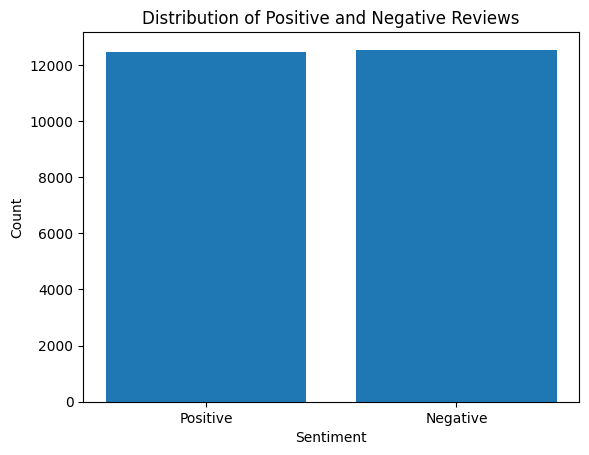

In [4]:
# Count the number of positive and negative reviews
positive_count = np.sum(sentiment == 1)
negative_count = np.sum(sentiment == 0)

# Plot the distribution of positive and negative reviews
labels = ['Positive', 'Negative']
counts = [positive_count, negative_count]

plt.bar(labels, counts)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Positive and Negative Reviews')
plt.show()
del positive_count, negative_count, labels, counts

Review length (in words):
Mean 89.08 words (51.254144)


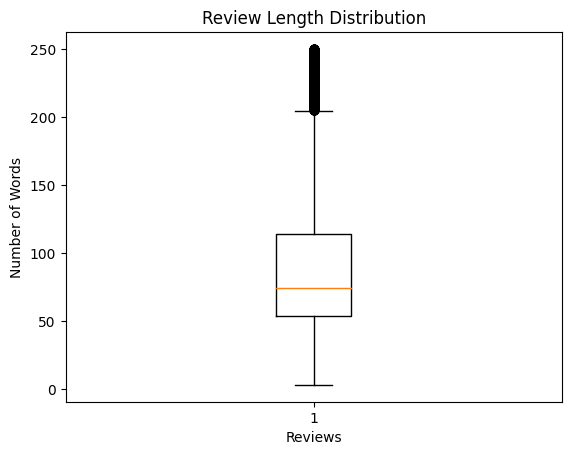

In [5]:
# Summarize review length in words
print("Review length (in words):")
result = [len(x.split()) for x in review]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

# Plot review length
plt.boxplot(result)
plt.xlabel('Reviews')
plt.ylabel('Number of Words')
plt.title('Review Length Distribution')
plt.show()
del result

In [6]:
# Count reviews with more than 500 words and store their indices
long_reviews_indices = [i for i, r in enumerate(review) if len(r.split()) > 150]
num_long_reviews = len(long_reviews_indices)

# Print the count and indices of long reviews
print("Number of reviews with more than 150 words:", num_long_reviews)
del long_reviews_indices, num_long_reviews

Number of reviews with more than 150 words: 3417


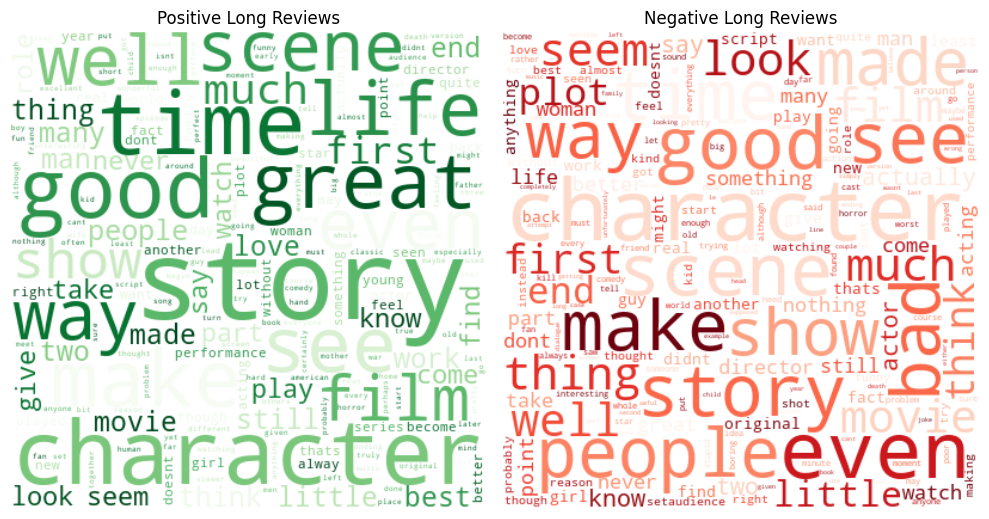

In [7]:
# Get long positive and negative reviews with 500 words or more
long_positive_reviews = [r for r, s in zip(review, sentiment) if len(r.split()) >= 150 and s == 1]
long_negative_reviews = [r for r, s in zip(review, sentiment) if len(r.split()) >= 150 and s == 0]

# Generate word clouds for long positive and negative reviews
positive_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Greens').generate(' '.join(long_positive_reviews))
negative_wordcloud = WordCloud(width=400, height=400, background_color='white', colormap='Reds').generate(' '.join(long_negative_reviews))

# Plot side-by-side subplots for positive and negative word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Long Reviews')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Long Reviews')
axes[1].axis('off')

plt.tight_layout()
plt.show()
del long_positive_reviews, long_negative_reviews, positive_wordcloud, negative_wordcloud

In [37]:
def preprocessing_data(review, word2vec_model_path = "Weights/word2vec_model_RNN.bin"):
    # Tokenize the text data
    tokenized_reviews = [review.split() for review in review]

    # # Train Word2Vec model on tokenized reviews
    # word2vec_model = Word2Vec(tokenized_reviews, vector_size=75, window=5, min_count=1, workers=4)

    # # Save Word2Vec model
    # word2vec_model.save("Weights/word2vec_model_RNN.bin")
    
    # Load Word2Vec model
    word2vec_model = Word2Vec.load(word2vec_model_path)

    # Convert text to word embeddings
    embedded_reviews = []
    for tokens in tokenized_reviews:
        embeddings = [word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv]
        embedded_reviews.append(embeddings)
    
    return embedded_reviews

reviews = preprocessing_data(review)
del review

In [33]:
from keras_preprocessing.sequence import pad_sequences
sequences = pad_sequences(reviews, maxlen=250, padding='post', truncating='post', dtype=np.float32)
del reviews

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_train, x_test, y_train, y_test = train_test_split(sequences, sentiment, test_size=0.2, stratify = sentiment)
y_cat_train = to_categorical(y_train,2)
y_cat_test = to_categorical(y_test,2) 
del sequences, sentiment

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, Input, PReLU
from keras.initializers import RandomUniform

model = Sequential()
model.add(Input(shape=(250, 75)))  # Specify the input shape as a tuple
model.add(Masking(mask_value=0))
model.add(LSTM(64, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))  
model.add(Dense(32))
model.add(PReLU(alpha_initializer=RandomUniform(minval=0.1, maxval=0.5)))  
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
model.load_weights("Weights/Sentiment Analysis RNN LSTM.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 250, 75)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                35840     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 p_re_lu (PReLU)             (None, 64)                64        
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 p_re_lu_1 (PReLU)           (None, 32)                32        
                                                                 
 dense_2 (Dense)             (None, 2)                 6

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=2, 
    mode='max'
)

In [ ]:
model.fit(x_train, y_cat_train,
          epochs = 10,
          verbose = 1,
          validation_data = (x_test, y_cat_test),
          callbacks = [early_stopping])

In [ ]:
#Save model
model.save('Weights/Sentiment Analysis RNN LSTM.h5')  

In [4]:
from keras_preprocessing.sequence import pad_sequences
def preprocessing_data(review, word2vec_model_path="Weights/word2vec_model_RNN.bin"):
    # Tokenize the text data
    tokenized_review = review.split()

    # Load Word2Vec model
    word2vec_model = Word2Vec.load(word2vec_model_path)

    # Convert text to word embeddings
    embeddings = np.array([word2vec_model.wv[word] for word in tokenized_review if word in word2vec_model.wv])
    embeddings = embeddings.reshape((1,) + embeddings.shape)
    sequence = pad_sequences(embeddings, maxlen=250, padding='post', truncating='post', dtype=np.float32)
    
    return sequence

In [7]:
summary = ["Negative","Positive"]
text = input()
text = clean_text(text)
text = preprocessing_data(text)
result = np.argmax(model.predict(text))
summary[result]

1/1 [==============================] - 0s 244ms/step


'Negative'